In [133]:
import pymc3 as pm
import numpy as np
import theano

from theano.compile.ops import as_op

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("/home/daniel/papers/thesis/thesis-style.mpl")

In [134]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

In [213]:
def background_rate_f(b, T, n):
    """
    
    """
    out = 0
    #n = int(n)
    for i in range(n+1):
        out += ((b*T)**i * np.exp(- b*T)) / np.math.factorial(i)
    return out

def log_background_rate(b, T, n):
    return np.log(background_rate_f(b, T, n))

def signal_rate_part(s, n, b, T):
    top_a = T * ((s + b) * T)**n 
    top_b = np.exp(-(s + b)*T)
    p = (top_a * top_b) / np.math.factorial(n)
    return theano.tensor.switch(theano.tensor.le(s, 0.), 0., p)

#@as_op(itypes=[T.dscalar, T.dscalar, T.dscalar, T.dscalar], otypes=[T.dscalar])
def log_signal_rate(s,n,b,T):
    #if theano.tensor.lt(0, s): return np.array([[0.0]])
    p = -log_background_rate(b,T,n) + np.log(signal_rate_part(s,n,b,T))
    
    return p

In [214]:
def number_mweg(volume):
    """
    Calculates the number of MWEGs in a volume, given in units of Mpc^3
    """
    return volume * (0.0116) 

In [215]:
def number_mweg_inspiral(inspiral):
    """
    Calculate the number of Milky Way equivalent galaxies 
    within a 3-sphere with a given inspiral radius. 
    
    Parameters
    ----------
    inspiral : float
        The insiral range for the detector.
    
    Notes
    ------
    Note the subtle difference between this funciton and `number_mweg`, 
    which expects the _horizon_ distance; these quantities differ
    by a factor of ~2.26 due to the inclusion of a correction for
    the antenna pattern.
    """
    return 4./3 * np.pi * inspiral**3 * (0.0116) #* horizon**3

In [454]:
priors = ["uniform", "jeffreys", 1.0, 0.5]

In [455]:
import theano.tensor as T
from pymc3 import DensityDist, Uniform, Normal
from pymc3 import Model
from pymc3 import distributions

def grb_model(number_events, background_rate, 
              observation_time, horizon,  grb_rate,
             efficiency_prior = "uniform"):
    with Model() as model:
        signal_rate = pm.DensityDist('signal_rate', 
                                     logp=lambda value: log_signal_rate(value, number_events, background_rate, observation_time), 
                                     testval=1.,
                           )

        #volume = pm.Normal("volume", volume, sigma_volume)
        volume = 4./3. * np.pi * (horizon)**3
        n_galaxy = number_mweg(volume)
    
        cbc_rate = pm.Deterministic('cbc_rate', signal_rate / n_galaxy)# * n_galaxy)
        #grb_rate = pm.Poisson('grb_rate', mu = grb_rate)
        grb_rate = (grb_rate /  number_mweg(1e9))# * observation_time
        
        # Allow the efficiency prior to be switched-out
        if efficiency_prior == "uniform":
            efficiency = pm.Uniform('efficiency', 0,1., testval=0.5)
        elif efficiency_prior == "jeffreys":
            efficiency = pm.Beta('efficiency', 0.5, 0.5, testval = 0.3)
        elif isinstance(efficiency_prior, float):
            efficiency = efficiency_prior
        
        def cosangle(cbc_rate, efficiency, grb_rate):
            return T.switch((grb_rate >= cbc_rate*efficiency), -np.Inf, 
             (1.0 - ((grb_rate/(cbc_rate*efficiency))))
                )
        
        costheta = pm.Deterministic('cos_angle', cosangle(cbc_rate, efficiency, grb_rate))

        angle = pm.Deterministic("angle", theano.tensor.arccos(costheta))
        
        return model

In [456]:
# 2015 - 2016 Scenario
number_events = 0 # There were no BNS detections in O1
background_rate = 0.01 # We take the FAR to be 1/100 yr
observation_time = 0.25 #46.1/365. # The number of days of analysis conducted by gstLAL
horizon = 70  # The O1 BNS horizon distance in O1 BNS paper
grb_rate = 10#10.0
o1_models = []


print "Volume: {}".format((np.pi * 4/3 * observation_time * horizon**3)/1e6)

for prior in priors:
    o1_models.append( grb_model(number_events, background_rate, observation_time, horizon, grb_rate, prior))

Volume: 0.35918876006


In [413]:
# 2016-2017 Scenarios
number_events = 1 # Assume O2 will see one BNS observation
background_rate = 0.01 # We take the FAR to be 1/100 yr
observation_time = 0.5 # The number of years of analysis conducted 
duty_cycle = 0.5
observation_time *= duty_cycle
horizon = 100.0  # The O1 BNS horizon distance in O1 BNS paper
grb_rate = 10.0
o2_models = []


print "Volume: {}".format((np.pi * 4/3 * observation_time * horizon**3)/1e6)

for prior in priors:
    o2_models.append( grb_model(number_events, background_rate, observation_time, horizon, grb_rate, prior))

Volume: 1.0471975512


In [414]:
# 2017-2018 Scenarios
number_events = 3 # Assume O2 will see one BNS observation
background_rate = 0.01 # We take the FAR to be 1/100 yr
observation_time = 0.75 # The number of years of analysis conducted 
duty_cycle = 0.7
observation_time *= duty_cycle
horizon = 145.0  # The O1 BNS horizon distance in O1 BNS paper
grb_rate = 10.0
o3_models = []


print "Volume: {}".format((np.pi * 4/3 * observation_time * horizon**3)/1e6)

for prior in priors:
    o3_models.append( grb_model(number_events, background_rate, observation_time, horizon, grb_rate, prior))

Volume: 6.70427653249


In [457]:
# 2019+ Scenarios
number_events = 10 # Assume O2 will see one BNS observation
background_rate = 0.01 # We take the FAR to be 1/100 yr
observation_time = 1.0 # The number of years of analysis conducted 
duty_cycle = 0.7
observation_time *= duty_cycle
horizon = 189.7  # The O1 BNS horizon distance in O1 BNS paper
grb_rate = 10.0
o4_models = []

print "Volume: {}".format((np.pi * 4/3 * observation_time * horizon**3)/1e6)

for prior in priors:
    o4_models.append( grb_model(number_events, background_rate, observation_time, horizon, grb_rate, prior))

Volume: 20.0165230949


In [458]:
# 2022+ Scenarios
number_events = 20 # Assume O2 will see one BNS observation
background_rate = 0.01 # We take the FAR to be 1/100 yr
observation_time = 1.0 # The number of years of analysis conducted 
duty_cycle = 1.0
observation_time *= duty_cycle
horizon = 212.15  # The O1 BNS horizon distance in O1 BNS paper
grb_rate = 10.0
print "Volume: {}".format((np.pi * 4/3 * observation_time * horizon**3)/1e6)
o5_models = []
for prior in priors:
    o5_models.append( grb_model(number_events, background_rate, observation_time, horizon, grb_rate, prior))

Volume: 39.9961066362


In [459]:
samples = 500000

In [418]:
o1_traces = []
for model in o1_models:
    with model:
        step = pm.Metropolis()
        o1_traces.append(pm.sample(samples, step))

100%|██████████| 500000/500000 [00:45<00:00, 11049.29it/s]


In [419]:
o2_traces = []    
for model in o2_models:
    with model:
        step = pm.Metropolis()
        o2_traces.append(pm.sample(samples, step))
        


100%|██████████| 500000/500000 [00:39<00:00, 12799.68it/s]


In [471]:
o3_traces = []
for model in o3_models:
    with model:
        step = pm.Metropolis()
        o3_traces.append(pm.sample(samples, step))
    

100%|██████████| 500000/500000 [00:46<00:00, 10735.60it/s]


In [460]:
o4_traces = []    
for model in o4_models:
    with model:
        step = pm.Metropolis()
        o4_traces.append(pm.sample(samples, step))
        
o5_traces = []    
for model in o5_models:
    with model:
        step = pm.Metropolis()
        o5_traces.append(pm.sample(samples, step))

100%|██████████| 500000/500000 [00:41<00:00, 12162.46it/s]


In [461]:
import matplotlib
import pymc3.stats

In [462]:
a = stats.gaussian_kde(data)

In [463]:
x = np.linspace(0,90, 200)
x[a.pdf(x).argmax()]

19.899497487437188

|Scenario|Lower	|MAP	|Median	|Upper	|
2015 -- 2016 & 0.00	 & 0.45	 & 2.75	 & 11.91	
2016 -- 2017 & 0.20	 & 4.07	 & 6.72	 & 19.05	
2017 -- 2018 & 1.37	 & 5.88	 & 6.99	 & 15.26	
2020+ & 7.30	 & 14.47	 & 15.25	 & 25.25	
2024+ & 12.42	 & 20.35	 & 20.65	 & 30.09	


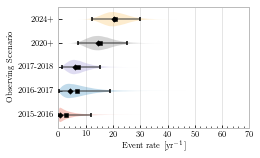

In [470]:
width = 3.487 #* 2
height = width / 1.618


f, ax = plt.subplots(1,1, sharex=True, figsize = (width, height))
priors = ["U(0,1)", "Jeffreys", "$\delta(1)$", "$\delta(0.5)$"]
scenarios = ["2015 -- 2016", "2016 -- 2017", "2017 -- 2018", "2020+", "2024+"]
print "|Scenario|Lower\t|MAP\t|Median\t|Upper\t|"

pos = [.5, 1, 1.5, 2, 2.5]

i = 0


for i, trace in enumerate([o1_traces, o2_traces, o3_traces, o4_traces, o5_traces]):
    #i = i/2.0
    data = trace[0][2000:]['signal_rate']

    parts = ax.violinplot(data, [pos[i]], points=200, widths=0.3, vert= False,
                     #showmeans = True, showmedians=True, 
                          bw_method="silverman",
                      showmeans=False, showextrema=False, showmedians=False)

    lower_p , medians, upper_p = np.percentile(data, [2.5, 50, 97.50])
    lower, upper = pymc3.stats.hpd(data, alpha=0.05)
    a = stats.gaussian_kde(data)
    x = np.linspace(0,90, 200)
    MAP = x[a.pdf(x).argmax()]



    ax.hlines(pos[i], lower, upper, color='#333333', linestyle='-', lw=2, alpha = 0.5)

    ax.scatter( [lower, upper], [pos[i]]*2, marker='|', color='k', s=15, zorder=3)
    ax.scatter( [MAP], pos[i], marker='D', color='k', s=15, zorder=3)
    ax.scatter( [medians], pos[i], marker='s', color='k', s=15, zorder=3)
    #ax2.vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)

    print "{} & {:.2f}\t & {:.2f}\t & {:.2f}\t & {:.2f}\t".format(scenarios[i], lower, MAP, medians, upper)


axis = ax
axis.set_yticks(pos)
axis.set_yticklabels(["2015-2016", "2016-2017", "2017-2018", "2020+", "2024+"])
axis.set_xlim([0, 70])
ax.get_xaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
#ax.get_yaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.grid(b=True, axis="x", which='major', linewidth=0.5)
ax.grid(b=True, axis="y", which='major', linewidth=0.)
#ax.grid(b=True, which='minor', linewidth=0.5)
ax.set_xlabel(r"Event rate [yr$^{-1}$]")
ax.set_ylabel(r"Observing Scenario")
f.subplots_adjust(0.21, 0.17, .97, .95, wspace=0.05)
f.savefig("../final_paper/rate_posteriors_violin.pdf")

In [425]:
def beaming_violins(traces, priors, xmax = 90):

    width = 3.487 #* 2
    height = width / 1.618


    f, ax = plt.subplots(1,1, sharex=True, figsize = (width, height))
    priors = ["U(0,1)", "Jeffreys", "$\delta(1)$", "$\delta(0.5)$"]
    print "|\t\t\t| Lower\t| MAP\t| Median\t| Upper\t|"
    print "|----------|"
    matplotlib.rcParams.update({'font.size': 10})
    pos = [.5, 1, 1.5, 2]

    for i in range(len(priors)):
        #i = i/2.0
        t_data = traces[i][2000:]['angle'][np.isfinite(traces[i][2000:]['angle'])]
        data = np.rad2deg(t_data)

        parts = ax.violinplot(data, [pos[i]], points=100, widths=0.3, vert= False,
                         #showmeans = True, showmedians=True, 
                          showmeans=False, showextrema=False, showmedians=False)

        lower_p, medians, upper_p = np.percentile(data, [2.5, 50, 97.50])
        lower, upper = pymc3.stats.hpd(t_data, alpha=0.05, transform=np.rad2deg)

        a = stats.gaussian_kde(data)
        x = np.linspace(0,90, 200)
        MAP = x[a.pdf(x).argmax()]



        ax.hlines(pos[i], lower, upper, color='#333333', linestyle='-', lw=2, alpha = 0.5)

        ax.scatter( [lower, upper], [pos[i]]*2, marker='|', color='k', s=15, zorder=3)
        ax.scatter( [MAP], pos[i], marker='D', color='k', s=15, zorder=3)
        ax.scatter( [medians], pos[i], marker='s', color='k', s=15, zorder=3)
        #ax2.vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)

        print "& {} \t & {:.2f}\t & {:.2f}\t& {:.2f}\t& {:.2f}\t \\\\".format(priors[i], lower, MAP, medians, upper)

        axis = ax
        axis.set_yticks(pos)
        axis.set_yticklabels(priors)
        axis.set_xlim([0, xmax])
        ax.get_xaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        ax.get_yaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        ax.grid(b=True, axis='x', which='major', linewidth=0.5)
        ax.grid(b=True, axis='y', which='major', linewidth=0)
        #ax.grid(b=True, which='minor', linewidth=0.5)
    ax.set_xlabel(r"Beaming Angle [$\theta$]")
    ax.set_ylabel(r"Prior Distribution on efficiency")
    ax.tick_params(axis='y',which='both',left='off')
    f.subplots_adjust(0.20, 0.15, .98, .95, wspace=0.05)
    #f.savefig("O2a_beaming_posteriors_violin.pdf")
    #f.savefig("O2a_beaming_posteriors_violin.png", dpi=300)
    return f

|			| Lower	| MAP	| Median	| Upper	|
|----------|
& U(0,1) 	 & 2.00	 & 5.43	& 9.24	& 40.17	 \\
& Jeffreys 	 & 1.90	 & 5.43	& 9.50	& 49.71	 \\
& $\delta(1)$ 	 & 1.76	 & 4.07	& 5.83	& 21.04	 \\
& $\delta(0.5)$ 	 & 2.51	 & 5.88	& 8.22	& 28.35	 \\


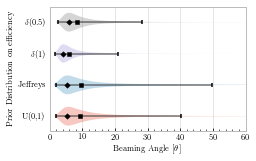

In [428]:
o1plot = beaming_violins(o1_traces, priors, xmax=60)
o1plot.savefig("../final_paper/O1_beaming_posteriors_violin.pdf")

|			| Lower	| MAP	| Median	| Upper	|
|----------|
& U(0,1) 	 & 3.09	 & 6.78	& 9.91	& 34.23	 \\
& Jeffreys 	 & 2.85	 & 6.78	& 9.91	& 46.93	 \\
& $\delta(1)$ 	 & 2.88	 & 5.43	& 6.40	& 14.15	 \\
& $\delta(0.5)$ 	 & 4.06	 & 7.69	& 9.07	& 20.05	 \\


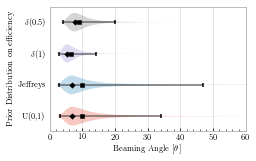

In [435]:
o2_plot = beaming_violins(o2_traces, priors, xmax=60)
o2_plot.savefig("../final_paper/O2_beaming_posteriors_violin.pdf")

|			| Lower	| MAP	| Median	| Upper	|
|----------|
& U(0,1) 	 & 6.71	 & 12.66	& 16.33	& 47.29	 \\
& Jeffreys 	 & 6.35	 & 11.76	& 15.85	& 57.19	 \\
& $\delta(1)$ 	 & 6.42	 & 9.95	& 10.97	& 18.44	 \\
& $\delta(0.5)$ 	 & 8.94	 & 14.02	& 15.55	& 26.01	 \\


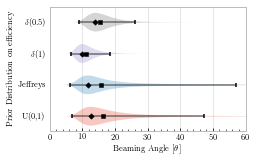

In [472]:
o3_plot = beaming_violins(o3_traces, priors, xmax=60)

|			| Lower	| MAP	| Median	| Upper	|
|----------|
& U(0,1) 	 & 8.20	 & 12.66	& 16.04	& 44.73	 \\
& Jeffreys 	 & 7.82	 & 12.21	& 15.35	& 56.99	 \\
& $\delta(1)$ 	 & 8.10	 & 10.85	& 11.12	& 14.95	 \\
& $\delta(0.5)$ 	 & 11.47	 & 14.92	& 15.75	& 21.17	 \\


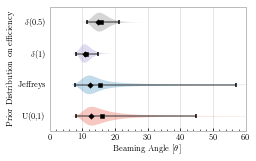

In [464]:
o4_plot = beaming_violins(o4_traces, priors, xmax=60)

In [465]:
o4_plot.savefig("o4_violins.png")

|			| Lower	| MAP	| Median	| Upper	|
|----------|
& U(0,1) 	 & 9.05	 & 13.12	& 16.07	& 45.10	 \\
& Jeffreys 	 & 8.58	 & 12.21	& 15.28	& 56.30	 \\
& $\delta(1)$ 	 & 9.09	 & 11.31	& 11.30	& 14.02	 \\
& $\delta(0.5)$ 	 & 12.82	 & 15.83	& 16.00	& 19.82	 \\


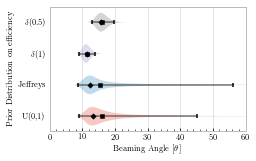

In [466]:
o5_plot = beaming_violins(o5_traces, priors, xmax=60)

In [467]:
o5_plot.savefig("o5_violins.png")

# Injection Tests

## O1-like scenario

In [501]:
test_scenarios = []
priors = ["uniform", "jeffreys", 0.5, 1.0]
for prior in priors:
    # O1 Scenarios
    number_events = 0 # There were no BNS detections in O1
    background_rate = 0.01 # We take the FAR to be 1/100 yr
    observation_time = 46.1/365. # The number of days of analysis conducted by gstLAL
    horizon = 73.2  # The O1 BNS horizon distance in O1 BNS paper
    grb_rate = 36.7
    o1_models = []
    test_scenarios.append(grb_model(number_events, background_rate, observation_time, horizon, grb_rate, prior))

In [504]:
samples = 500000
traces = []
for test_model in test_scenarios:
    with test_model as model:
            step = pm.Metropolis()
            traces.append( pm.sample(samples, step) )
            #angles.append(np.rad2deg(np.nanmean(trace['angle'])))

100%|██████████| 500000/500000 [00:36<00:00, 13662.52it/s]


injected at: 10.0454502788

    \toprule
    Prior & Lower & MAP & Median & Upper\\
          & [$^\circ$] & [$^\circ$]& [$^\circ$]& [$^\circ$] \\
    \colrule

U(0,1) & 4.62	 & 8.14	 & 13.23	 & 63.81	 \
Jeffreys & 4.38	 & 7.69	 & 13.23	 & 69.74	 \
$\delta(0.5)$ & 5.24	 & 8.59	 & 11.89	 & 50.51	 \
$\delta(1.0)$ & 3.68	 & 5.88	 & 8.45	 & 39.44	 \


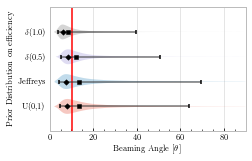

In [507]:
width = 3.487 #* 2
height = width / 1.618

f, ax = plt.subplots(1,1, sharex=True, figsize = (width, height))
priors = ["U(0,1)", "Jeffreys", "$\delta(0.5)$", "$\delta(1.0)$"]
pos = np.arange(4)/2.
cbc_rate = np.mean(traces[0]['cbc_rate'])

injected = np.arccos(1 - 2*(grb_rate/  number_mweg(1e9)) / cbc_rate)


ax.vlines(np.rad2deg(injected), -0.5,2, 'r')

print "injected at: {}".format(np.rad2deg(injected))

print r"""
    \toprule
    Prior & Lower & MAP & Median & Upper\\
          & [$^\circ$] & [$^\circ$]& [$^\circ$]& [$^\circ$] \\
    \colrule
"""

for i, trace in enumerate(traces):
    data = np.rad2deg(trace[2000:]['angle'][np.isfinite(trace[2000:]['angle'])])
    parts = ax.violinplot(data, 
                          [pos[i]], points=200, widths=0.3, vert= False,
                     #showmeans = True, showmedians=True, 
                      showmeans=False, showextrema=False, showmedians=False)

    lower, medians, upper = np.percentile(data, [2.5, 50, 97.50])
    a = stats.gaussian_kde(data)
    x = np.linspace(0,90, 200)
    MAP = x[a.pdf(x).argmax()]
    

    ax.hlines(pos[i], lower, upper, color='#333333', linestyle='-', lw=2, alpha = 0.5)

    ax.scatter( [lower, upper], [pos[i]]*2, marker='|', color='k', s=15, zorder=3)
    ax.scatter( [MAP], pos[i], marker='D', color='k', s=15, zorder=3)
    ax.scatter( [medians], pos[i], marker='s', color='k', s=15, zorder=3)
    print "{} & {:.2f}\t & {:.2f}\t & {:.2f}\t & {:.2f}\t \\".format(priors[i], lower, MAP, medians, upper)
    axis = ax
    axis.set_yticks(pos)
    axis.set_yticklabels(priors)
    ax.set_ylim(-0.5, 2.0)
    ax.grid(b=True, axis='x', which='major', linewidth=0.5)
    #axis.set_xlim([0, 35])
    ax.get_xaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.grid(b=True, axis='x', which='major', linewidth=0.5)
    ax.grid(b=True, axis='y', which='major', linewidth=0)
    #ax.grid(b=True, which='minor', linewidth=0.5)
ax.set_xlim([0,90])
ax.tick_params(axis='y',which='both',left='off')
ax.set_xlabel(r"Beaming Angle [$\theta$]")
ax.set_ylabel(r"Prior Distribution on efficiency")
f.subplots_adjust(0.20, 0.15, .98, .95, wspace=0.05)
f.savefig("../final_paper/O1_injections_violin.pdf")

## O2-like scenario

In [545]:
test_scenarios = []
priors = ["uniform", "jeffreys", 0.5, 1.0]
for prior in priors:
    # O1 Scenarios
    grb_rate = 27.98
    number_events = 1 # Assume O2 will see one BNS observation
    background_rate = 0.01 # We take the FAR to be 1/100 yr
    observation_time = 0.5 # The number of years of analysis conducted 
    duty_cycle = 0.5
    observation_time *= duty_cycle
    horizon = 80.0  # The O1 BNS horizon distance in O1 BNS paper
    
    test_scenarios.append(grb_model(number_events, background_rate, observation_time, horizon, grb_rate, prior))

In [546]:
samples = 5000
traces = []
for test_model in test_scenarios:
    with test_model as model:
            step = pm.Metropolis()
            traces.append( pm.sample(samples, step) )
            

100%|██████████| 5000/5000 [00:00<00:00, 10737.65it/s]


injected at: 9.9378227909

    \toprule
    Prior & Lower & MAP & Median & Upper\\
          & [$^\circ$] & [$^\circ$]& [$^\circ$]& [$^\circ$] \\
    \colrule

U(0,1) & 5.12	 & 9.05	 & 11.29	 & 51.04	 \
Jeffreys & 5.05	 & 9.05	 & 12.21	 & 62.72	 \
$\delta(0.5)$ & 6.11	 & 9.50	 & 10.88	 & 27.88	 \
$\delta(1.0)$ & 4.15	 & 6.78	 & 7.62	 & 21.17	 \
\botrule


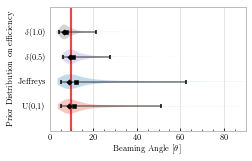

In [547]:
width = 3.487 #* 2
height = width / 1.618


f, ax = plt.subplots(1,1, sharex=True, figsize = (width, height))

priors = ["U(0,1)", "Jeffreys", "$\delta(0.5)$", "$\delta(1.0)$"]
pos = np.arange(4)/2.
cbc_rate = np.mean(traces[0]['cbc_rate'])
injected = np.arccos(1 - 2*grb_rate/  number_mweg(1e9) / cbc_rate)

print "injected at: {}".format(np.rad2deg(injected))

print r"""
    \toprule
    Prior & Lower & MAP & Median & Upper\\
          & [$^\circ$] & [$^\circ$]& [$^\circ$]& [$^\circ$] \\
    \colrule
"""

ax.vlines(np.rad2deg(injected), -0.5,2, 'r')
for i, trace in enumerate(traces):
    data = np.rad2deg(trace[2000:]['angle'][np.isfinite(trace[2000:]['angle'])])
    parts = ax.violinplot(data, 
                          [pos[i]], points=200, widths=0.3, vert= False,
                     #showmeans = True, showmedians=True, 
                      showmeans=False, showextrema=False, showmedians=False)

    lower, medians, upper = np.percentile(data, [2.5, 50, 97.50])
    a = stats.gaussian_kde(data)
    x = np.linspace(0,90, 200)
    MAP = x[a.pdf(x).argmax()]
    

    ax.hlines(pos[i], lower, upper, color='#333333', linestyle='-', lw=2, alpha = 0.5)

    ax.scatter( [lower, upper], [pos[i]]*2, marker='|', color='k', s=15, zorder=3)
    ax.scatter( [MAP], pos[i], marker='D', color='k', s=15, zorder=3)
    ax.scatter( [medians], pos[i], marker='s', color='k', s=15, zorder=3)
    print "{} & {:.2f}\t & {:.2f}\t & {:.2f}\t & {:.2f}\t \\".format(priors[i], lower, MAP, medians, upper)
    axis = ax
    axis.set_yticks(pos)
    axis.set_yticklabels(priors)
    ax.set_ylim(-0.5, 2.0)
    ax.grid(b=True, axis='x', which='major', linewidth=0.5)
    
    ax.grid(b=True, axis='y', which='major', linewidth=0)
    #axis.set_xlim([0, 35])
    ax.get_xaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.set_xlim([0,90])
print r"\botrule"
ax.tick_params(axis='y',which='both',left='off')
ax.set_xlabel(r"Beaming Angle [$\theta$]")
ax.set_ylabel(r"Prior Distribution on efficiency")
f.subplots_adjust(0.20, 0.15, .98, .95, wspace=0.05)
f.savefig("../final_paper/O2_injections_violin.pdf")